### Source

The 'glass' data used here can be downloaded from [here](https://archive.ics.uci.edu/ml/machine-learning-databases/glass/).

### Notes:

Type of glass: (class attribute)
1. building_windows_float_processed
2. building_windows_non_float_processed
3. vehicle_windows_float_processed
4. vehicle_windows_non_float_processed (none in this database)
5. containers
6. tableware
7. headlamps

### Imports

In [170]:
import os
import itertools
import warnings
import numpy as np
import pandas as pd
import seaborn as sns

from scipy import stats
from sklearn import datasets
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

#Reset some default parameters.
warnings.filterwarnings('ignore')
sns.set(style="white")
fs = 20.
RS = 1234126

### 1) Load Data

In [171]:
fpath = os.path.join('./data', 'glass.data')
columns = ['Id', 'RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe', 'Type']
df = pd.read_csv(fpath, names=columns)

print('Dataframe shape is: {}'.format(df.shape))
df.head(n=10)

Dataframe shape is: (214, 11)


,Id,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.00,1
1,2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.00,1
2,3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.00,1
3,4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.00,1
4,5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.00,1
5,6,1.51596,12.79,3.61,1.62,72.97,0.64,8.07,0.0,0.26,1
6,7,1.51743,13.30,3.60,1.14,73.09,0.58,8.17,0.0,0.00,1
7,8,1.51756,13.15,3.61,1.05,73.24,0.57,8.24,0.0,0.00,1
8,9,1.51918,14.04,3.58,1.37,72.08,0.56,8.30,0.0,0.00,1
9,10,1.51755,13.00,3.60,1.36,72.99,0.57,8.40,0.0,0.11,1


### 2) Data Description

#### 2.1) Summary

In [172]:
df.describe()

,Id,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,107.500000,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009,2.780374
std,61.920648,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439,2.103739
min,1.000000,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000,1.000000
25%,54.250000,1.516523,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000,1.000000
50%,107.500000,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000,2.000000
75%,160.750000,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000,3.000000
max,214.000000,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000,7.000000


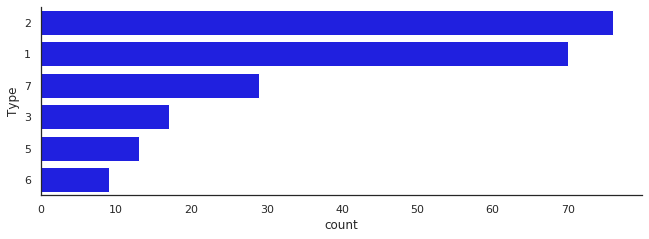

In [173]:
g = sns.catplot(
  data=df, y='Type', kind='count', order = df['Type'].value_counts().index, color='blue')
g.fig.set_size_inches(10,3)

#### 2.2 Correlation Matrix

(9.0, 0.0)

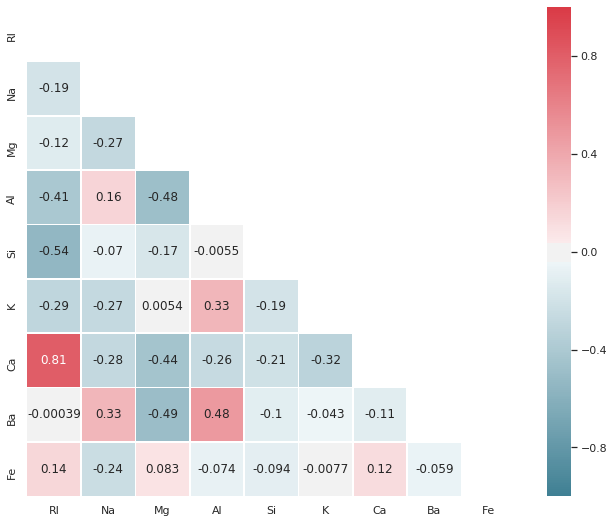

In [174]:
#Compute correlation. Include only relevant columns (i.e., remove id and Type.)
aux_cols = list(columns)
aux_cols.remove('Id')
aux_cols.remove('Type')
corr = df[aux_cols].corr()

#Mask top triangle, as it is redundant information.
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1., vmax=1., center=0,
            annot=True, square=True, linewidths=.5)

#Fix y-axis limits.
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

#### 2.3) Type vs Composition

In [175]:
#Re-scale variables such that the quantities are comparable.
cols = ['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe']

#Create a new column for each attribute containing the zscores.
for col in cols:
    z_scores = stats.zscore(df[col])
    df[col + '_zscore'] = z_scores


(6.0, 0.0)

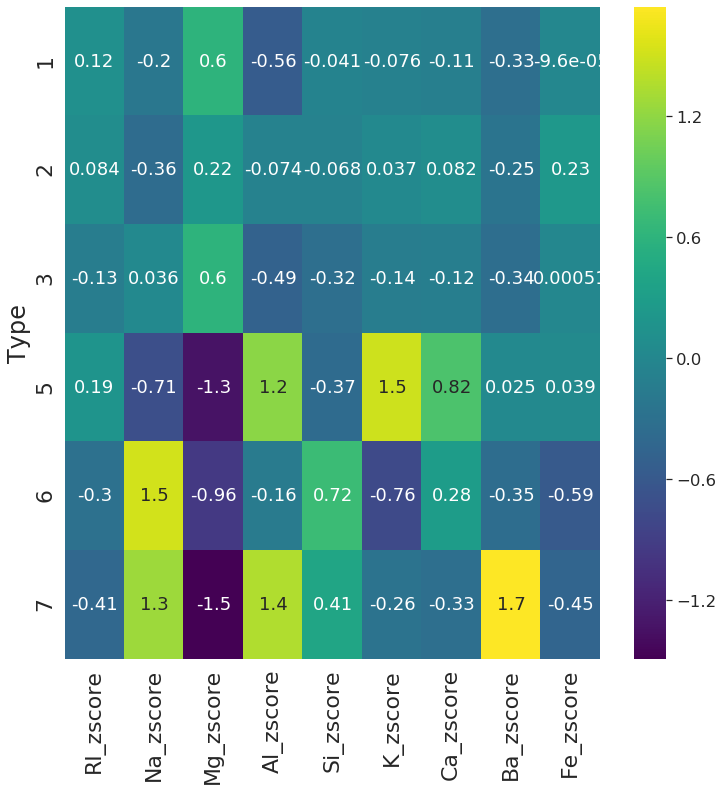

In [176]:
cols = ['RI_zscore', 'Na_zscore', 'Mg_zscore', 'Al_zscore', 'Si_zscore',
        'K_zscore', 'Ca_zscore', 'Ba_zscore', 'Fe_zscore', 'Type']

aux = df[cols].groupby(['Type']).mean()

sns.set(font_scale=2)
fig, ax = plt.subplots(figsize=(12,12))
sns.set(font_scale=1.5)
sns.heatmap(aux, cmap='viridis', annot=True, ax=ax)

#Fix first and last rows. (Bug in recent matplotlib)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

#### Corner Plot

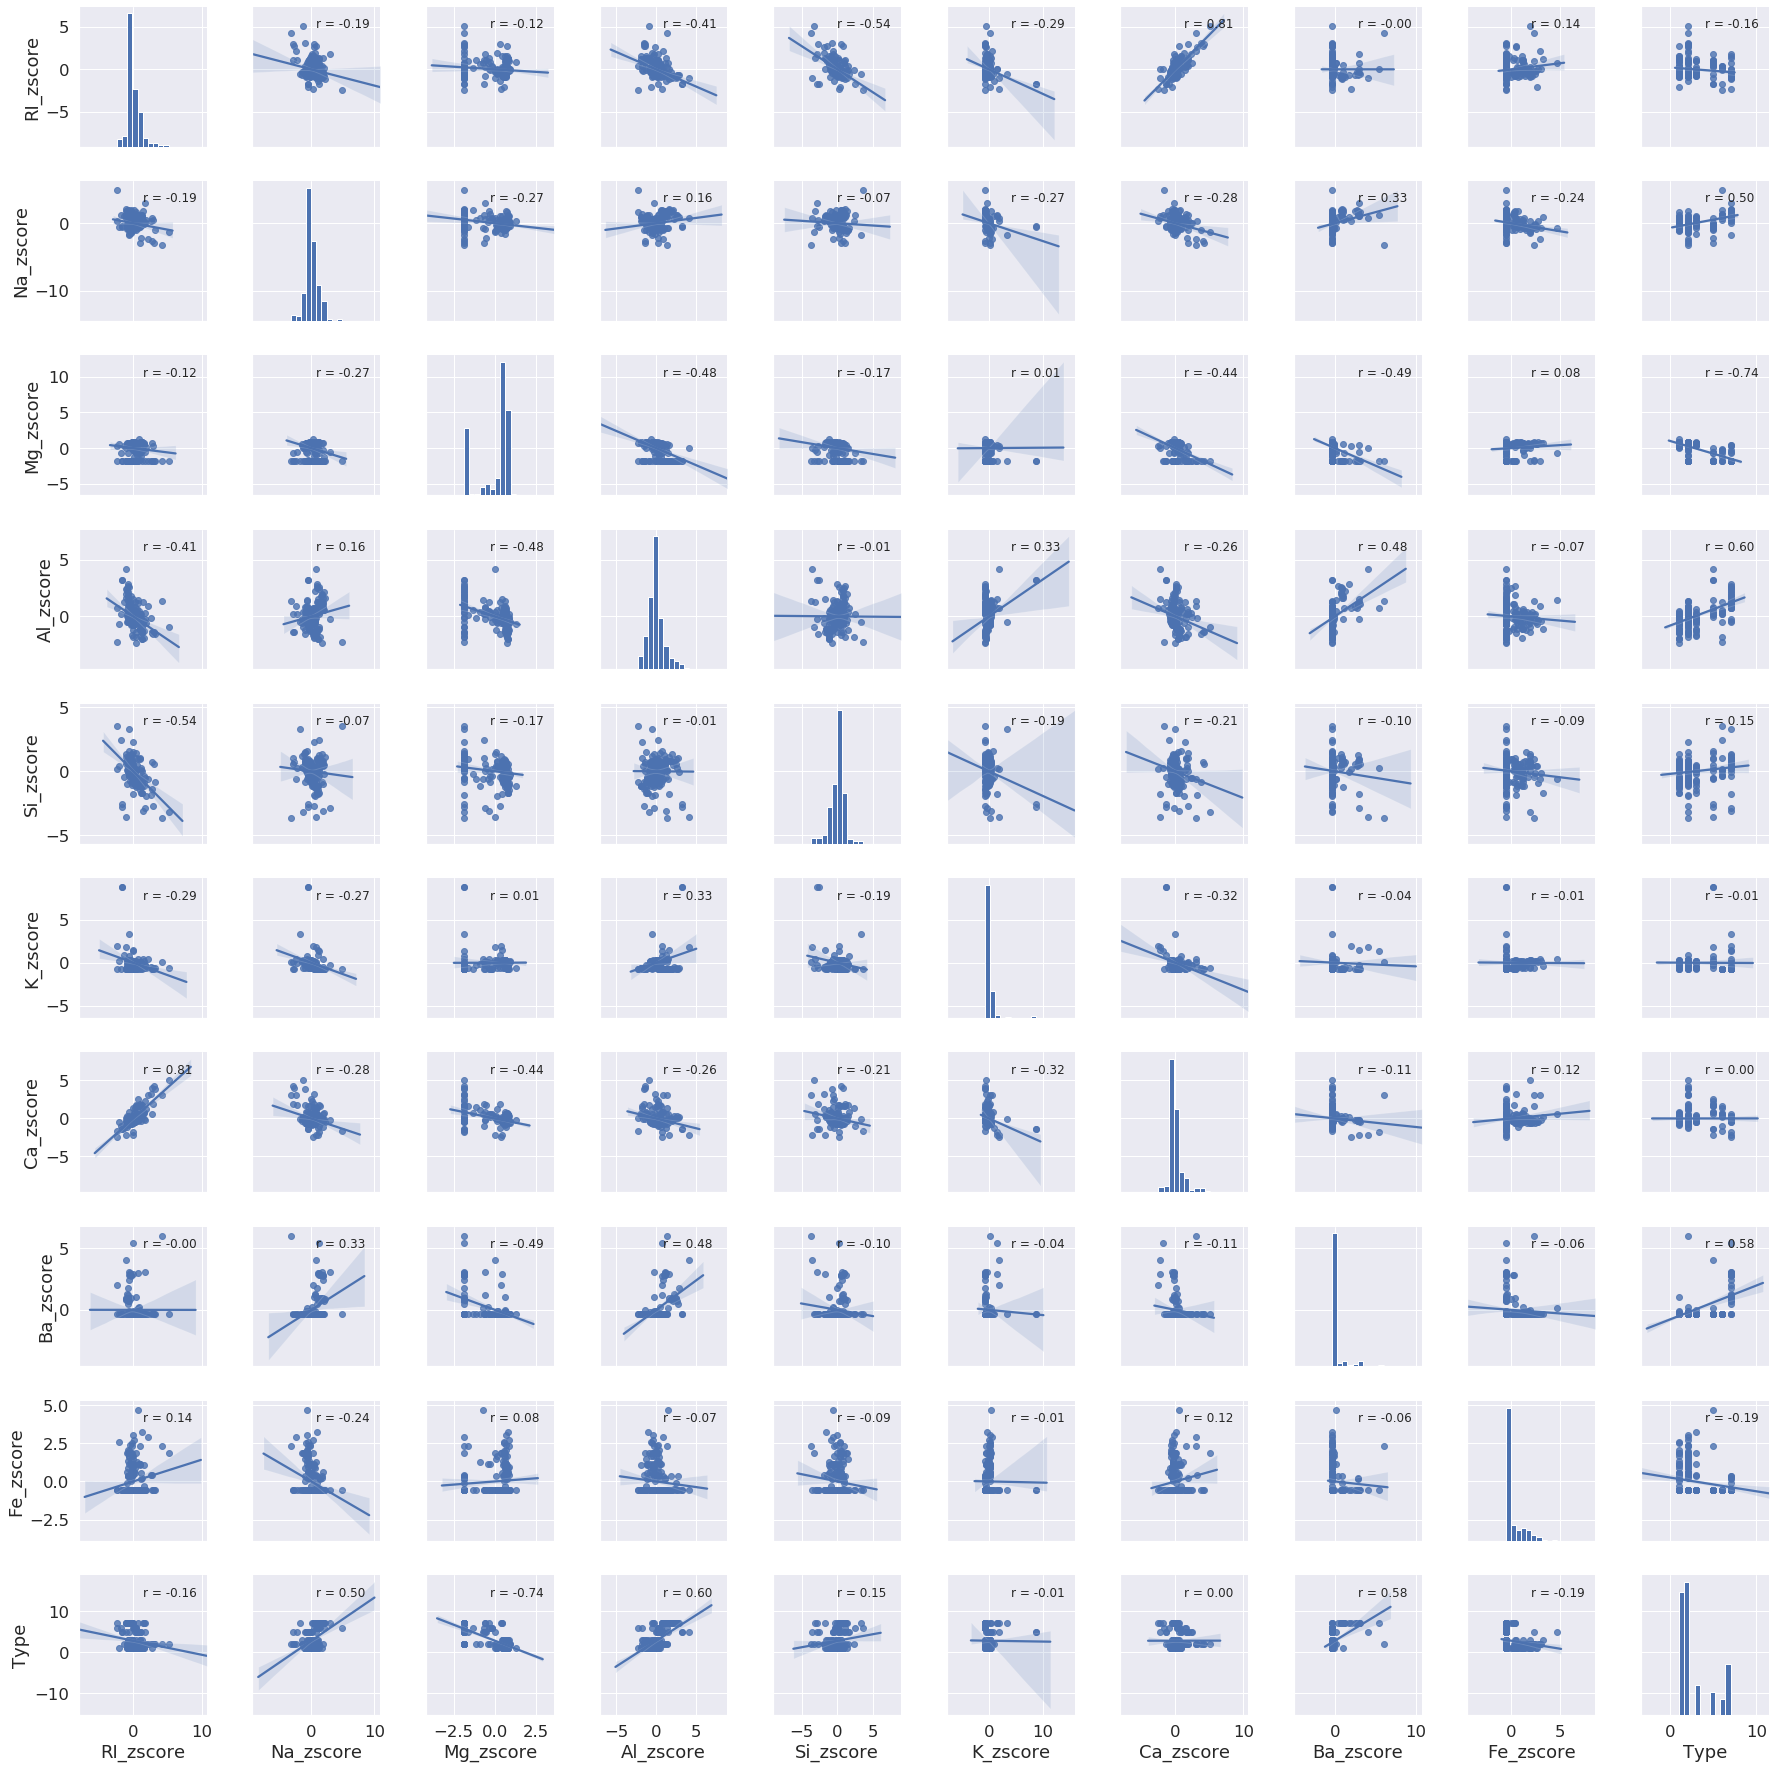

In [177]:
cols = ['RI_zscore', 'Na_zscore', 'Mg_zscore', 'Al_zscore', 'Si_zscore',
        'K_zscore', 'Ca_zscore', 'Ba_zscore', 'Fe_zscore', 'Type']
aux = df[cols]

#Calculate person stats for each plot.
coeffs = [format(stats.pearsonr(aux[c1], aux[c2])[0], '.2f')
          for (c1,c2) in list(itertools.product(cols,cols))]

g = sns.pairplot(aux, kind='reg')

for i, ax in enumerate(g.axes.flat):
    if i % 11 != 0:
        ax.text(0.5, 0.85,'r = {}'.format(coeffs[i]), fontsize=12, transform=ax.transAxes)

#### 2.4) Partial Conclusions

+ Data consists of:
  + Two main attributes: index of refraction (IR) and usage (Type)
  + Composition: Na, Mg, Al, Si, K, Ca, Ba, Fe.
+ The IR exhibits a short range, such that IR belong to [1.511, 1.534], with a median of 1.517.
+ There are 7 different types of glasses. More info can be found in './data/glass.names'
  + Most common types are 2 (building_windows_non_float_processed) and 1 (building_windows_float_processed)
+ Correlations:
  + The index of refraction is primarily determined by the amount of Ca in the composition. Secondary factors are Si and Al. An increase in ca will tend ti increase the IR whereas and increase in Si or Al will have the oppposite effect.
+ Types vc Composition
  + Types 1, 2 and 3 have a balanced distribution of elements.
  + Types 6 and 7 require a relatively high amount of Na.
  + Types 5 and 7 require a relatively low amount of Mg and high amount of Al.
  + While Type 5 further requires a high amount of K, Type 7 reguires a high amount of Ba.
  + Fe is present is relatively moderate amounts in all types.
+ Corner Plot:
  + Mg shows a bimodal distribution.
  + Most elements are fairly independent of the others. HIghest correlations are only moderate, [0.4--0.5], between Mg and Al and Mg and Ca.
  + Reinforces that IR is highly correlated with Ca
  
  


### 3) Data Preparation

In [178]:
#Check if there are any null values.
df.isnull().values.any()

False

In [179]:
#Split dataset into train and validation.
cols = ['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe']
X = df[cols]
y = df['Type']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RS)

In [180]:
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

### 4) Baseline Model

In [181]:
#Train model.
knn = KNeighborsClassifier(n_neighbors=9, p=2, metric='minkowski')
knn.fit(X_train_std, y_train)

#Calculate predictions.
y_pred = knn.predict(X_test_std)

In [182]:
#Show how well it performed.
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))
print('Misclassified samples: %d/%d' % ((y_test != y_pred).sum(), len(y_pred) ))

Accuracy: 0.67
Misclassified samples: 14/43


### 5) Model tuning

#### 5.1) Calculations

In [183]:
#Create list of neighbors to test. Include only odd numbers
K_list = list(range(1,52,2))

N_folds = 10
cv_scores = np.zeros(len(K_list))

for i, K in enumerate(K_list):
    knn = KNeighborsClassifier(n_neighbors=K)
    scores = cross_val_score(knn, X_train_std, y_train, cv=N_folds, scoring='accuracy')
    cv_scores[i] = scores.mean()

#### 5.2) Visualization

The optimal number of neighbors is 1


Text(0, 0.5, 'Misclassification Error')

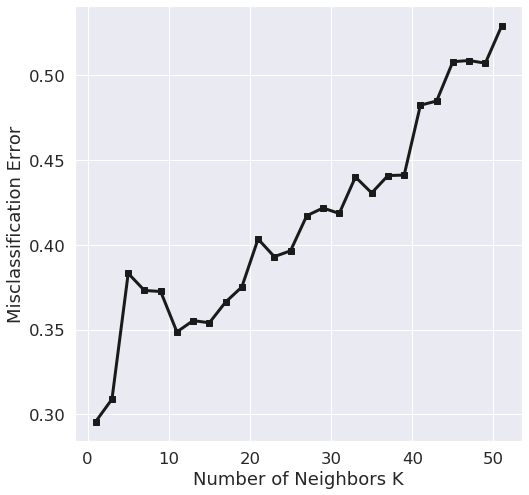

In [184]:
#Calculate y variable as error.
MSE = np.array([1 - x for x in cv_scores])

#Print out the best k
optimal_k = K_list[MSE.argmin()]
print("The optimal number of neighbors is %d" % optimal_k)

# plot misclassification error vs k
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(K_list, MSE, ls='-', marker='s', lw=3., color='k')
ax.set_xlabel('Number of Neighbors K')
ax.set_ylabel('Misclassification Error')


#### 5.3) Partial Conclusions

+ The preferred number of neighbor is 1 because it gives the lowest error.

### 6-7) Weighted and Custom Distances

#### 6-7.1) Calculations

In [185]:
#Define custom weight functions.
def custom_dist_exp(distances):
    #return 1. #Uniform option
    #return (1./distances) #'distance' option
    return np.exp(-distances)

def custom_dist_pl(distances):
    return distances**-1.5

In [186]:
#We can repeat the analysis while using the 'distance' weight and see if it improves the model accuracy.
K_list = list(range(1,52,2))
N_folds = 10
weight_type = ['uniform', 'distance', 'custom_pl', 'custom_exp']
out = {w:np.zeros(len(K_list)) for w in weight_type}

for w in ['uniform', 'distance']:
    for i, K in enumerate(K_list):
        knn = KNeighborsClassifier(n_neighbors=K, weights=w)
        scores = cross_val_score(knn, X_train_std, y_train, cv=N_folds, scoring='accuracy')
        out[w][i] = scores.mean()

In [187]:
#Use custom distances for calculations.
for i, K in enumerate(K_list):
    #Exponential dist.
    knn_exp = KNeighborsClassifier(n_neighbors=K, weights=custom_dist_exp)
    scores_exp = cross_val_score(knn_exp, X_train_std, y_train, cv=N_folds, scoring='accuracy')
    out['custom_exp'][i] = scores_exp.mean()
    
    #Power-law dist.
    knn_pl = KNeighborsClassifier(n_neighbors=K, weights=custom_dist_pl)
    scores_pl = cross_val_score(knn_pl, X_train_std, y_train, cv=N_folds, scoring='accuracy')
    out['custom_pl'][i] = scores_pl.mean()

#### 6-7.2) Make Plot

The optimal number of neighbors for distance=uniform is 1
The optimal number of neighbors for distance=distance is 3
The optimal number of neighbors for distance=custom_pl is 3
The optimal number of neighbors for distance=custom_exp is 3


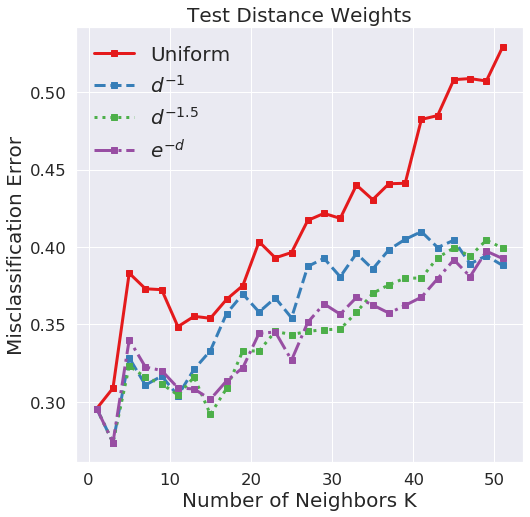

In [188]:
#Make plot.
fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlabel('Number of Neighbors K', fontsize=fs)
ax.set_ylabel('Misclassification Error', fontsize=fs)
ax.set_title('Test Distance Weights', fontsize=fs)
colors = ['#e41a1c','#377eb8','#4daf4a','#984ea3']
ls = ['-', '--', ':', '-.']
w2label = {'uniform':'Uniform', 'distance':r'$d^{-1}$',
           'custom_exp':r'$e^{-d}$', 'custom_pl':r'$d^{-1.5}$'}

for j, w in enumerate(weight_type):
    MSE = np.array([1 - x for x in out[w]])
    optimal_k = K_list[MSE.argmin()]
    print("The optimal number of neighbors for distance=%s is %d" % (w, optimal_k))

    # plot misclassification error vs k
    ax.plot(K_list, MSE, ls=ls[j], marker='s', lw=3., color=colors[j], label=w2label[w])

ax.legend(frameon=False, loc=2, numpoints=1, fontsize=fs)

#### 6-7.3) Partial Conclusions

+ Using custom weights can greatly improve the model's accuracy, without over-fitting.
+ While the custom weights seem effective to improve the accuracy for lar number of neighbors (>10), the best models remain at a comparable precision level with the 'distance' metric.
  + This suggests that the nearby points contribute much more significantly towards the classification.
  + Using the new metrics, the optimal number of neighbors is 3.

### 8) Data Normalization

#### 8.1) Calculations

In [189]:
#Update calculations by using scikit-learn normalize.
X_train_norm = normalize(X_train)
X_test_norm = normalize(X_test)

In [190]:
K_list = list(range(1,52,2))
N_folds = 10
weight_type = ['uniform', 'distance', 'custom_pl', 'custom_exp']
out = {w:np.zeros(len(K_list)) for w in weight_type}

for w in ['uniform', 'distance']:
    for i, K in enumerate(K_list):
        knn = KNeighborsClassifier(n_neighbors=K, weights=w)
        scores = cross_val_score(knn, X_train_norm, y_train, cv=N_folds, scoring='accuracy')
        out[w][i] = scores.mean()

In [191]:
#Use custom distances for calculations.
for i, K in enumerate(K_list):
    #Exponential dist.
    knn_exp = KNeighborsClassifier(n_neighbors=K, weights=custom_dist_exp)
    scores_exp = cross_val_score(knn_exp, X_train_std, y_train, cv=N_folds, scoring='accuracy')
    out['custom_exp'][i] = scores_exp.mean()
    
    #Power-law dist.
    knn_pl = KNeighborsClassifier(n_neighbors=K, weights=custom_dist_pl)
    scores_pl = cross_val_score(knn_pl, X_train_std, y_train, cv=N_folds, scoring='accuracy')
    out['custom_pl'][i] = scores_pl.mean()

#### 8.2) Make Plot

The optimal number of neighbors for distance=uniform is 1
The optimal number of neighbors for distance=distance is 1
The optimal number of neighbors for distance=custom_pl is 3
The optimal number of neighbors for distance=custom_exp is 3


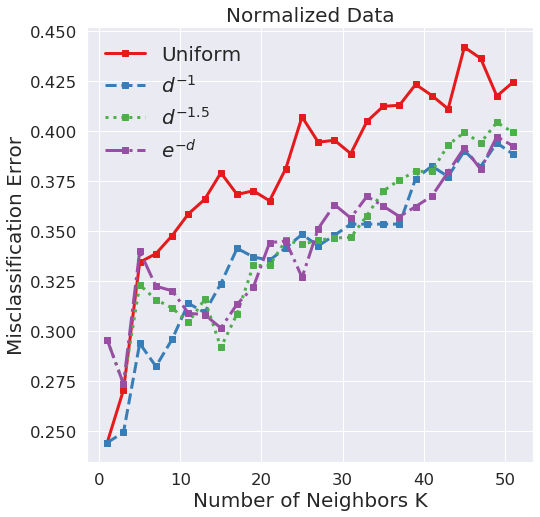

In [192]:
#Make plot.
fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlabel('Number of Neighbors K', fontsize=fs)
ax.set_ylabel('Misclassification Error', fontsize=fs)
ax.set_title('Normalized Data', fontsize=fs)
colors = ['#e41a1c','#377eb8','#4daf4a','#984ea3']
ls = ['-', '--', ':', '-.']
w2label = {'uniform':'Uniform', 'distance':r'$d^{-1}$',
           'custom_exp':r'$e^{-d}$', 'custom_pl':r'$d^{-1.5}$'}

for j, w in enumerate(weight_type):
    MSE = np.array([1 - x for x in out[w]])
    optimal_k = K_list[MSE.argmin()]
    print("The optimal number of neighbors for distance=%s is %d" % (w, optimal_k))

    # plot misclassification error vs k
    ax.plot(K_list, MSE, ls=ls[j], marker='s', lw=3., color=colors[j], label=w2label[w])

ax.legend(frameon=False, loc=2, numpoints=1, fontsize=fs)

#### 8.3) Partial Conclusions

+ Using scikit normalize the overall accuracy improves, and the optimal number of neighbors is reduced to 1, previously being 3.
+ The optimal metric among the ones tested here is 'distace'.

### 9) Dimensionality Reduction

#### 9.1) Define Function for PCA Operation

In [193]:
cols = ['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe']
X = df[cols]
y = df['Type']

def reduce_data(X, n_dim):
    pca = PCA(n_components=n_dim, random_state=RS)
    pca.fit(X)
    return pca.transform(X), pca.explained_variance_ratio_

#### 9.2) Assess the Best Number of Dimensions

[0.47620525 0.73939801 0.84719844 0.94922308 0.98229031 0.99833805
 0.99976548 0.99999985 1.        ]


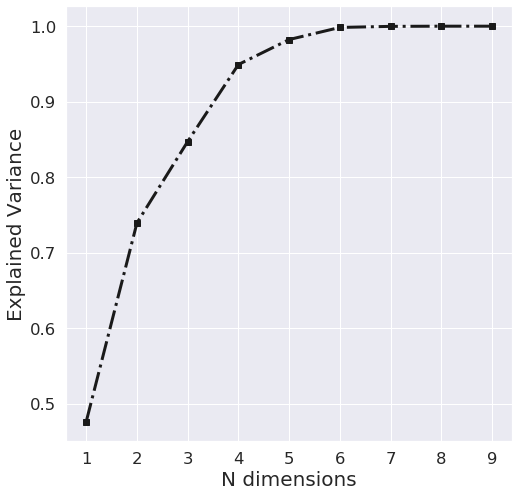

In [194]:
exp_var = np.cumsum(reduce_data(X, X.shape[1])[1])
print(exp_var)

fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlabel('N dimensions', fontsize=fs)
ax.set_ylabel('Explained Variance', fontsize=fs)
ax.plot(np.arange(X.shape[1]) + 1, exp_var, ls=ls[j], marker='s', lw=3., color='k')

#### 9.3) Reduce Data using Optimal Number of Dimensions

In [195]:
#From the plot above, 5 is a good compromise between explaining variance and using few dimensions.
n_dim = 5
X_red = reduce_data(X, n_dim)[0]

### 10) Applying KNN Using the Reduced Data

#### 10.1) Prepare the Data

In [196]:
X_train_red, X_test_red, y_train_red, y_test_red = train_test_split(
    X_red, y, test_size=0.2, random_state=RS)

X_train_norm_red = normalize(X_train_red)
X_test_norm_red = normalize(X_test_red)

#### 10.2) Apply KNN

In [197]:
K_list = list(range(1,52,2))
N_folds = 10
weight_type = ['uniform', 'distance', 'custom_pl', 'custom_exp']
out = {w:np.zeros(len(K_list)) for w in weight_type}

for w in ['uniform', 'distance']:
    for i, K in enumerate(K_list):
        knn = KNeighborsClassifier(n_neighbors=K, weights=w)
        scores = cross_val_score(knn, X_train_norm_red, y_train_red, cv=N_folds, scoring='accuracy')
        out[w][i] = scores.mean()

In [198]:
#Use custom distances for calculations.
for i, K in enumerate(K_list):
    #Exponential dist.
    knn_exp = KNeighborsClassifier(n_neighbors=K, weights=custom_dist_exp)
    scores_exp = cross_val_score(knn_exp, X_train_norm_red, y_train_red, cv=N_folds, scoring='accuracy')
    out['custom_exp'][i] = scores_exp.mean()
    
    #Power-law dist.
    knn_pl = KNeighborsClassifier(n_neighbors=K, weights=custom_dist_pl)
    scores_pl = cross_val_score(knn_pl, X_train_norm_red, y_train_red, cv=N_folds, scoring='accuracy')
    out['custom_pl'][i] = scores_pl.mean()

#### 10.3) Make Plot

The optimal number of neighbors for distance=uniform is 1
The optimal number of neighbors for distance=distance is 9
The optimal number of neighbors for distance=custom_pl is 7
The optimal number of neighbors for distance=custom_exp is 1


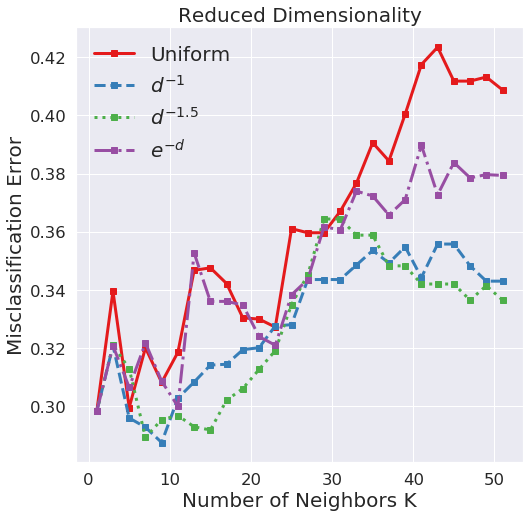

In [199]:
#Make plot.
fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlabel('Number of Neighbors K', fontsize=fs)
ax.set_ylabel('Misclassification Error', fontsize=fs)
ax.set_title('Reduced Dimensionality', fontsize=fs)
colors = ['#e41a1c','#377eb8','#4daf4a','#984ea3']
ls = ['-', '--', ':', '-.']
w2label = {'uniform':'Uniform', 'distance':r'$d^{-1}$',
           'custom_exp':r'$e^{-d}$', 'custom_pl':r'$d^{-1.5}$'}

for j, w in enumerate(weight_type):
    MSE = np.array([1 - x for x in out[w]])
    optimal_k = K_list[MSE.argmin()]
    print("The optimal number of neighbors for distance=%s is %d" % (w, optimal_k))

    # plot misclassification error vs k
    ax.plot(K_list, MSE, ls=ls[j], marker='s', lw=3., color=colors[j], label=w2label[w])

ax.legend(frameon=False, loc=2, numpoints=1, fontsize=fs)

#### 10.4) Partial Conclusions

+ PCA was used to reduce the dimensionality from 9 to 5, which is sufficient to explain 98.2% of the variance in the data.
+ As expected, the model accuracy was comparable, but slightly higher, compared to when the whole data was used. The upside being that the KNN calculations were likely faster.
+ The optimal number of neighbors is 9 for the 'distance' weights, which provide the best model by a small margin.

### 11) General Conclusions

+ Applying KNN to the glass dataset has yielded an accuracy of about 75%.
+ The choice of number of neighbors is relevant, as it led to a factor of two variation in the accuracy.
+ The choice of weight metric is not obvious nor unique. Some realizations of the test/train split favoured custom metrics. Overall, the 'distance' metric seems to always be reliable for this dataset, while the 'uniform' metric is sub-optimal.
+ Normalizing the data via scikit normalize (rather than using StandardScaler) led to a marginal impromevent of a few percent in the accuracy.
+ Using PCA to reduce dimensionality can speed the calculation at the expense of a few percent of accuracy.